In [1]:
import numpy as np 
import pandas as pd
# 시각화 package
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
from sklearn.tree import export_graphviz

import matplotlib.font_manager as font_manager
from matplotlib import rc
   
# 한글폰트작업
# window의 폰트 위치 -> C:/Windows/Fonts/NGULIM.TTF
font_name = font_manager.FontProperties(fname="C:/Windows/Fonts/NGULIM.TTF").get_name()
rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False

# <font color = 4247D6> Data Set

In [2]:
df = pd.read_csv('이상치_제거_.csv')
df

,STD_DT,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,TAG
0,2020-03-04 0:00,489,116,631,OK
1,2020-03-04 0:00,433,78,609,OK
2,2020-03-04 0:00,464,154,608,OK
3,2020-03-04 0:00,379,212,606,OK
4,2020-03-04 0:00,798,1736,604,OK
...,...,...,...,...,...
835195,2020-04-30 23:59,755,1743,318,OK
835196,2020-04-30 23:59,385,206,317,OK
835197,2020-04-30 23:59,465,148,316,OK
835198,2020-04-30 23:59,467,0,314,OK


In [3]:
df.replace({'TAG': {'OK': 1, 'NG': 0}}, inplace=True)
df

,STD_DT,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,TAG
0,2020-03-04 0:00,489,116,631,1
1,2020-03-04 0:00,433,78,609,1
2,2020-03-04 0:00,464,154,608,1
3,2020-03-04 0:00,379,212,606,1
4,2020-03-04 0:00,798,1736,604,1
...,...,...,...,...,...
835195,2020-04-30 23:59,755,1743,318,1
835196,2020-04-30 23:59,385,206,317,1
835197,2020-04-30 23:59,465,148,316,1
835198,2020-04-30 23:59,467,0,314,1


In [4]:
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from imblearn.over_sampling import SMOTE

In [5]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from tcn import TCN, tcn_full_summary
from keras.layers import Dropout
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [6]:
df['STD_DT'] = df['STD_DT'].apply(lambda x: pd.to_datetime(str(x), format = '%Y-%m-%d %H:%M:%S'))

In [7]:
df = df.set_index(['STD_DT'])
df

,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,TAG
STD_DT,,,,
2020-03-04 00:00:00,489,116,631,1
2020-03-04 00:00:00,433,78,609,1
2020-03-04 00:00:00,464,154,608,1
2020-03-04 00:00:00,379,212,606,1
2020-03-04 00:00:00,798,1736,604,1
...,...,...,...,...
2020-04-30 23:59:00,755,1743,318,1
2020-04-30 23:59:00,385,206,317,1
2020-04-30 23:59:00,465,148,316,1


In [8]:
# df.replace({'TAG': {'OK': 1, 'NG': 0}}, inplace=True)
df1 = df[['MELT_TEMP', 'MOTORSPEED', 'MELT_WEIGHT', 'TAG']]
df1

,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,TAG
STD_DT,,,,
2020-03-04 00:00:00,489,116,631,1
2020-03-04 00:00:00,433,78,609,1
2020-03-04 00:00:00,464,154,608,1
2020-03-04 00:00:00,379,212,606,1
2020-03-04 00:00:00,798,1736,604,1
...,...,...,...,...
2020-04-30 23:59:00,755,1743,318,1
2020-04-30 23:59:00,385,206,317,1
2020-04-30 23:59:00,465,148,316,1


In [9]:
split_date = int(df1.shape[0]*0.7)
train = df1[:split_date]
test = df1[split_date:]
print(train.shape)
print(test.shape)

(584640, 4)
(250560, 4)


In [10]:
scaler = preprocessing.MinMaxScaler()

train_sc = scaler.fit_transform(train)
test_sc = scaler.transform(test)

x_train_values = train_sc[:, :-1]
y_train_values = train_sc[:,-1]

In [11]:
smote = SMOTE(random_state = 0)

X_train_over, y_train_over = smote.fit_resample(x_train_values, y_train_values)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트', x_train_values.shape, y_train_values.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트 (584640, 3) (584640,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트 (821032, 3) (821032,)
SMOTE 적용 후 레이블 값 분포: 
 1.0    410516
0.0    410516
dtype: int64


In [12]:
def make_dataset(data, label, window_size):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [13]:
X_train_over = pd.DataFrame(X_train_over, columns = ['MELT_TEMP', 'MOTORSPEED', 'MELT_WEIGHT'])
y_train_over = pd.DataFrame(y_train_over, columns = ['TAG'])

In [14]:
#train dataset
train_feature, train_label = make_dataset(X_train_over, y_train_over, 10)

In [15]:
test_sc = pd.DataFrame(test_sc, columns = ['MELT_TEMP', 'MOTORSPEED', 'MELT_WEIGHT','TAG'])

In [16]:
feature_cols = ['MELT_TEMP', 'MOTORSPEED', 'MELT_WEIGHT']
label_cols = ['TAG']

In [17]:
test_feature = test_sc[feature_cols]
test_label = test_sc[label_cols]

# test dataset (실제 예측 해볼 데이터)
test_feature, test_label = make_dataset(test_feature, test_label, 10)
test_feature.shape, test_label.shape

((250550, 10, 3), (250550, 1))

In [18]:
import os
path = "C:/Users/islab/Desktop/jihyeon/전자제조시스템"
os.chdir(path)

In [19]:
model_path = path

Epoch 1/200
57471/57472 [============================>.] - ETA: 0s - loss: 0.3473 - accuracy: 0.8077
Epoch 1: val_loss improved from inf to 0.33819, saving model to C:/Users/islab/Desktop/jihyeon/전자제조시스템\tmp_checkpoint.h5
57472/57472 [==============================] - 179s 3ms/step - loss: 0.3473 - accuracy: 0.8077 - val_loss: 0.3382 - val_accuracy: 0.8157
Epoch 2/200
57466/57472 [============================>.] - ETA: 0s - loss: 0.3368 - accuracy: 0.8136
Epoch 2: val_loss improved from 0.33819 to 0.33731, saving model to C:/Users/islab/Desktop/jihyeon/전자제조시스템\tmp_checkpoint.h5
57472/57472 [==============================] - 177s 3ms/step - loss: 0.3368 - accuracy: 0.8136 - val_loss: 0.3373 - val_accuracy: 0.8160
Epoch 3/200
57470/57472 [============================>.] - ETA: 0s - loss: 0.3363 - accuracy: 0.8139
Epoch 3: val_loss improved from 0.33731 to 0.33552, saving model to C:/Users/islab/Desktop/jihyeon/전자제조시스템\tmp_checkpoint.h5
57472/57472 [==============================] - 178s 

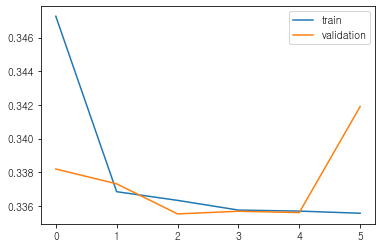

[[  2189    751]
 [ 76574 171036]]


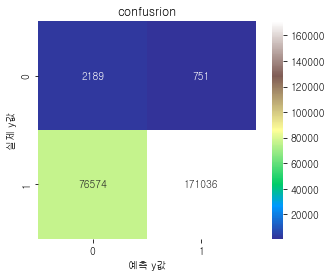

precision : 0.99563
recall : 0.69075
f1-score : 0.81563
accuracy : 0.69138
Epoch 1/200
57456/57472 [============================>.] - ETA: 0s - loss: 0.3496 - accuracy: 0.8078
Epoch 1: val_loss improved from inf to 0.33592, saving model to C:/Users/islab/Desktop/jihyeon/전자제조시스템\tmp_checkpoint.h5
57472/57472 [==============================] - 187s 3ms/step - loss: 0.3496 - accuracy: 0.8078 - val_loss: 0.3359 - val_accuracy: 0.8122
Epoch 2/200
57459/57472 [============================>.] - ETA: 0s - loss: 0.3382 - accuracy: 0.8137
Epoch 2: val_loss did not improve from 0.33592
57472/57472 [==============================] - 184s 3ms/step - loss: 0.3382 - accuracy: 0.8137 - val_loss: 0.3381 - val_accuracy: 0.8144
Epoch 3/200
57471/57472 [============================>.] - ETA: 0s - loss: 0.3368 - accuracy: 0.8141
Epoch 3: val_loss improved from 0.33592 to 0.33548, saving model to C:/Users/islab/Desktop/jihyeon/전자제조시스템\tmp_checkpoint.h5
57472/57472 [==============================] - 182s 3ms

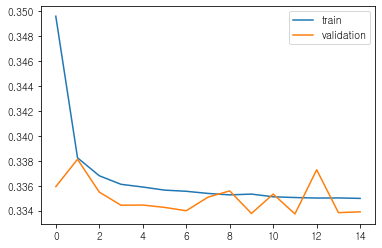

[[  2162    778]
 [ 62627 184983]]


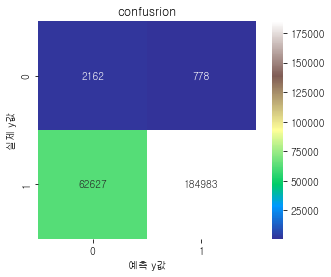

precision : 0.99581
recall : 0.74707
f1-score : 0.85369
accuracy : 0.74694
Epoch 1/200
57459/57472 [============================>.] - ETA: 0s - loss: 0.3481 - accuracy: 0.8068
Epoch 1: val_loss improved from inf to 0.33633, saving model to C:/Users/islab/Desktop/jihyeon/전자제조시스템\tmp_checkpoint.h5
57472/57472 [==============================] - 220s 4ms/step - loss: 0.3481 - accuracy: 0.8068 - val_loss: 0.3363 - val_accuracy: 0.8122
Epoch 2/200
57465/57472 [============================>.] - ETA: 0s - loss: 0.3374 - accuracy: 0.8133
Epoch 2: val_loss improved from 0.33633 to 0.33430, saving model to C:/Users/islab/Desktop/jihyeon/전자제조시스템\tmp_checkpoint.h5
57472/57472 [==============================] - 224s 4ms/step - loss: 0.3374 - accuracy: 0.8133 - val_loss: 0.3343 - val_accuracy: 0.8179
Epoch 3/200
57459/57472 [============================>.] - ETA: 0s - loss: 0.3368 - accuracy: 0.8142
Epoch 3: val_loss improved from 0.33430 to 0.33429, saving model to C:/Users/islab/Desktop/jihyeon/전자제

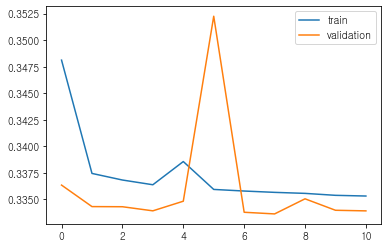

[[  2166    774]
 [ 63703 183907]]


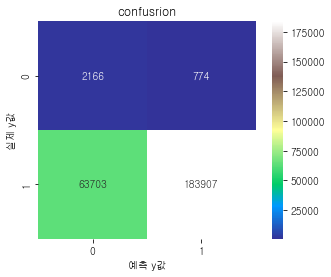

precision : 0.99581
recall : 0.74273
f1-score : 0.85085
accuracy : 0.74266
Epoch 1/200
57460/57472 [============================>.] - ETA: 0s - loss: 0.3496 - accuracy: 0.8067
Epoch 1: val_loss improved from inf to 0.33600, saving model to C:/Users/islab/Desktop/jihyeon/전자제조시스템\tmp_checkpoint.h5
57472/57472 [==============================] - 237s 4ms/step - loss: 0.3496 - accuracy: 0.8067 - val_loss: 0.3360 - val_accuracy: 0.8139
Epoch 2/200
57471/57472 [============================>.] - ETA: 0s - loss: 0.3373 - accuracy: 0.8135
Epoch 2: val_loss improved from 0.33600 to 0.33371, saving model to C:/Users/islab/Desktop/jihyeon/전자제조시스템\tmp_checkpoint.h5
57472/57472 [==============================] - 238s 4ms/step - loss: 0.3373 - accuracy: 0.8135 - val_loss: 0.3337 - val_accuracy: 0.8166
Epoch 3/200
57467/57472 [============================>.] - ETA: 0s - loss: 0.3368 - accuracy: 0.8141
Epoch 3: val_loss did not improve from 0.33371
57472/57472 [==============================] - 241s 4ms

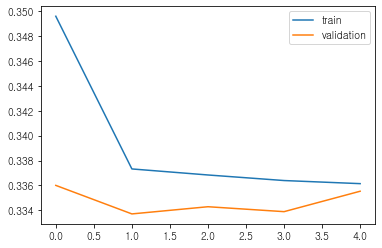

[[  2162    778]
 [ 61119 186491]]


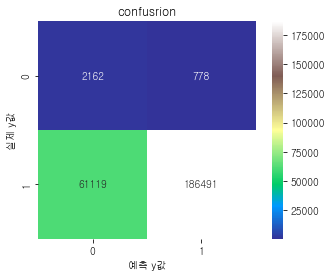

precision : 0.99585
recall : 0.75316
f1-score : 0.85767
accuracy : 0.75296
Epoch 1/200
57459/57472 [============================>.] - ETA: 0s - loss: 0.3469 - accuracy: 0.8079
Epoch 1: val_loss improved from inf to 0.33592, saving model to C:/Users/islab/Desktop/jihyeon/전자제조시스템\tmp_checkpoint.h5
57472/57472 [==============================] - 245s 4ms/step - loss: 0.3469 - accuracy: 0.8079 - val_loss: 0.3359 - val_accuracy: 0.8119
Epoch 2/200
57464/57472 [============================>.] - ETA: 0s - loss: 0.3370 - accuracy: 0.8140
Epoch 2: val_loss improved from 0.33592 to 0.33511, saving model to C:/Users/islab/Desktop/jihyeon/전자제조시스템\tmp_checkpoint.h5
57472/57472 [==============================] - 242s 4ms/step - loss: 0.3370 - accuracy: 0.8140 - val_loss: 0.3351 - val_accuracy: 0.8160
Epoch 3/200
57462/57472 [============================>.] - ETA: 0s - loss: 0.3363 - accuracy: 0.8145
Epoch 3: val_loss did not improve from 0.33511
57472/57472 [==============================] - 241s 4ms

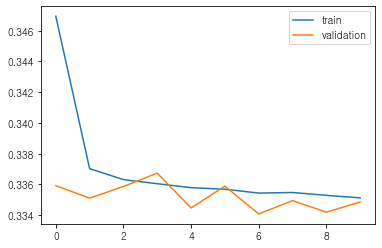

[[  1646   1294]
 [ 50763 196847]]


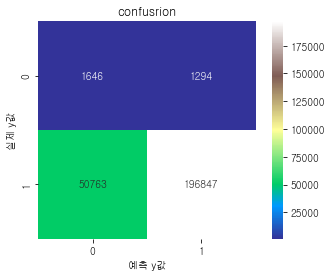

precision : 0.99347
recall : 0.79499
f1-score : 0.88322
accuracy : 0.79223
Epoch 1/200
57471/57472 [============================>.] - ETA: 0s - loss: 0.3487 - accuracy: 0.8072
Epoch 1: val_loss improved from inf to 0.34002, saving model to C:/Users/islab/Desktop/jihyeon/전자제조시스템\tmp_checkpoint.h5
57472/57472 [==============================] - 195s 3ms/step - loss: 0.3487 - accuracy: 0.8072 - val_loss: 0.3400 - val_accuracy: 0.8117
Epoch 2/200
57465/57472 [============================>.] - ETA: 0s - loss: 0.3369 - accuracy: 0.8140
Epoch 2: val_loss improved from 0.34002 to 0.33530, saving model to C:/Users/islab/Desktop/jihyeon/전자제조시스템\tmp_checkpoint.h5
57472/57472 [==============================] - 190s 3ms/step - loss: 0.3369 - accuracy: 0.8140 - val_loss: 0.3353 - val_accuracy: 0.8156
Epoch 3/200
57461/57472 [============================>.] - ETA: 0s - loss: 0.3365 - accuracy: 0.8149
Epoch 3: val_loss did not improve from 0.33530
57472/57472 [==============================] - 188s 3ms

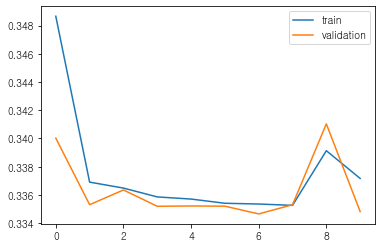

[[  2162    778]
 [ 62565 185045]]


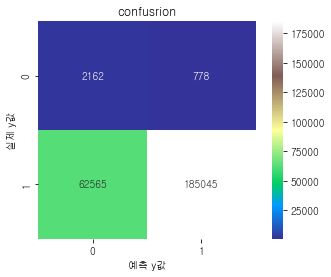

precision : 0.99581
recall : 0.74732
f1-score : 0.85386
accuracy : 0.74718
Epoch 1/200
57457/57472 [============================>.] - ETA: 0s - loss: 0.3491 - accuracy: 0.8065
Epoch 1: val_loss improved from inf to 0.34062, saving model to C:/Users/islab/Desktop/jihyeon/전자제조시스템\tmp_checkpoint.h5
57472/57472 [==============================] - 185s 3ms/step - loss: 0.3491 - accuracy: 0.8065 - val_loss: 0.3406 - val_accuracy: 0.8129
Epoch 2/200
57456/57472 [============================>.] - ETA: 0s - loss: 0.3373 - accuracy: 0.8137
Epoch 2: val_loss improved from 0.34062 to 0.33565, saving model to C:/Users/islab/Desktop/jihyeon/전자제조시스템\tmp_checkpoint.h5
57472/57472 [==============================] - 185s 3ms/step - loss: 0.3373 - accuracy: 0.8137 - val_loss: 0.3356 - val_accuracy: 0.8121
Epoch 3/200
57458/57472 [============================>.] - ETA: 0s - loss: 0.3364 - accuracy: 0.8146
Epoch 3: val_loss did not improve from 0.33565
57472/57472 [==============================] - 220s 4ms

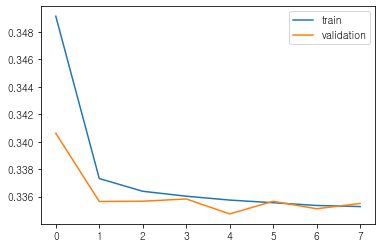

[[  2162    778]
 [ 61503 186107]]


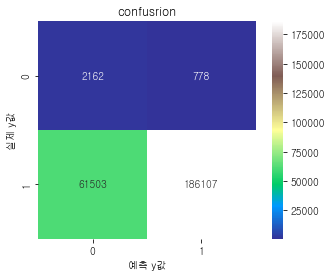

precision : 0.99584
recall : 0.75161
f1-score : 0.85666
accuracy : 0.75142
Epoch 1/200
57458/57472 [============================>.] - ETA: 0s - loss: 0.3529 - accuracy: 0.8041
Epoch 1: val_loss improved from inf to 0.33619, saving model to C:/Users/islab/Desktop/jihyeon/전자제조시스템\tmp_checkpoint.h5
57472/57472 [==============================] - 202s 3ms/step - loss: 0.3529 - accuracy: 0.8041 - val_loss: 0.3362 - val_accuracy: 0.8144
Epoch 2/200
57469/57472 [============================>.] - ETA: 0s - loss: 0.3379 - accuracy: 0.8123
Epoch 2: val_loss improved from 0.33619 to 0.33343, saving model to C:/Users/islab/Desktop/jihyeon/전자제조시스템\tmp_checkpoint.h5
57472/57472 [==============================] - 195s 3ms/step - loss: 0.3379 - accuracy: 0.8123 - val_loss: 0.3334 - val_accuracy: 0.8119
Epoch 3/200
57464/57472 [============================>.] - ETA: 0s - loss: 0.3370 - accuracy: 0.8138
Epoch 3: val_loss did not improve from 0.33343
57472/57472 [==============================] - 201s 4ms

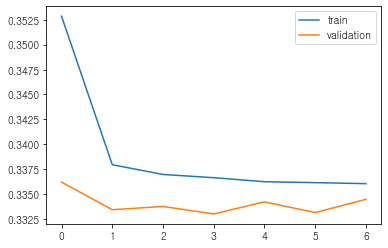

[[  1454   1486]
 [ 49404 198206]]


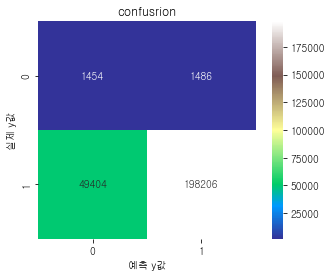

precision : 0.99256
recall : 0.80048
f1-score : 0.88623
accuracy : 0.79689
Epoch 1/200
57463/57472 [============================>.] - ETA: 0s - loss: 0.3502 - accuracy: 0.8062
Epoch 1: val_loss improved from inf to 0.34121, saving model to C:/Users/islab/Desktop/jihyeon/전자제조시스템\tmp_checkpoint.h5
57472/57472 [==============================] - 219s 4ms/step - loss: 0.3502 - accuracy: 0.8062 - val_loss: 0.3412 - val_accuracy: 0.8114
Epoch 2/200
57465/57472 [============================>.] - ETA: 0s - loss: 0.3379 - accuracy: 0.8135
Epoch 2: val_loss improved from 0.34121 to 0.33677, saving model to C:/Users/islab/Desktop/jihyeon/전자제조시스템\tmp_checkpoint.h5
57472/57472 [==============================] - 215s 4ms/step - loss: 0.3379 - accuracy: 0.8135 - val_loss: 0.3368 - val_accuracy: 0.8129
Epoch 3/200
57470/57472 [============================>.] - ETA: 0s - loss: 0.3363 - accuracy: 0.8144
Epoch 3: val_loss did not improve from 0.33677
57472/57472 [==============================] - 208s 4ms

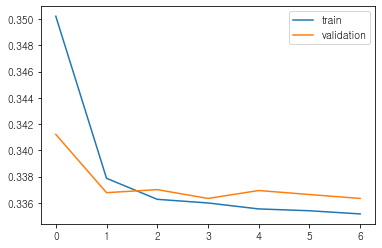

[[  2163    777]
 [ 60825 186785]]


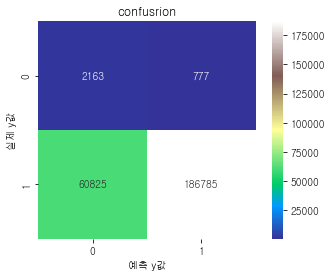

precision : 0.99586
recall : 0.75435
f1-score : 0.85844
accuracy : 0.75413
Epoch 1/200
57469/57472 [============================>.] - ETA: 0s - loss: 0.3482 - accuracy: 0.8074
Epoch 1: val_loss improved from inf to 0.33852, saving model to C:/Users/islab/Desktop/jihyeon/전자제조시스템\tmp_checkpoint.h5
57472/57472 [==============================] - 229s 4ms/step - loss: 0.3482 - accuracy: 0.8074 - val_loss: 0.3385 - val_accuracy: 0.8137
Epoch 2/200
57472/57472 [==============================] - ETA: 0s - loss: 0.3387 - accuracy: 0.8131
Epoch 2: val_loss did not improve from 0.33852
57472/57472 [==============================] - 225s 4ms/step - loss: 0.3387 - accuracy: 0.8131 - val_loss: 0.3396 - val_accuracy: 0.8134
Epoch 3/200
57459/57472 [============================>.] - ETA: 0s - loss: 0.3367 - accuracy: 0.8143
Epoch 3: val_loss improved from 0.33852 to 0.33679, saving model to C:/Users/islab/Desktop/jihyeon/전자제조시스템\tmp_checkpoint.h5
57472/57472 [==============================] - 225s 4ms

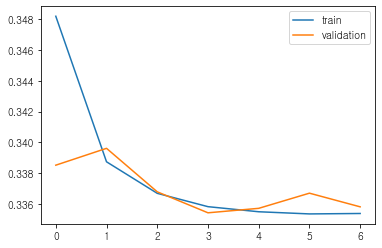

[[  2169    771]
 [ 63116 184494]]


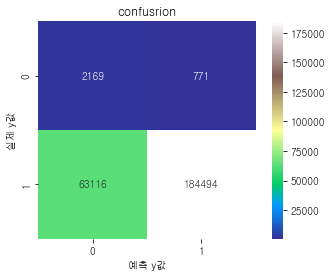

precision : 0.99584
recall : 0.74510
f1-score : 0.85241
accuracy : 0.74501


In [35]:
for i in range(0,20,2):
    x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size = 0.3, random_state=i)
    model = Sequential()
    model.add(LSTM(50, 
                   input_shape = (train_feature.shape[1], train_feature.shape[2]), activation = 'tanh', return_sequences = False))
    model.add(Dense(1, activation = 'sigmoid'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    early_stop = EarlyStopping(monitor = 'val_loss', patience = 3)
    filename = os.path.join(model_path, 'tmp_checkpoint.h5')
    checkpoint = ModelCheckpoint(filename, monitor = 'val_loss', verbose = 1, save_best_only = True, mode = 'auto')
    
    history = model.fit(x_train, y_train, epochs = 200, batch_size = 10, 
                        validation_data = (x_valid, y_valid), callbacks = [early_stop, checkpoint])
    
    pred = model.predict(test_feature)
    
    plt.plot(history.history["loss"],label="train")
    plt.plot(history.history["val_loss"],label="validation")
    plt.legend()
    plt.show()
    
    pred_df = pd.DataFrame(pred, columns=['TAG'])
    pred_df['TAG'] = pred_df['TAG'].apply(lambda x: 1 if x>=0.5 else 0)
    
    confusion = confusion_matrix(test_label, pred_df)
    print(confusion)
    
    plot = sns.heatmap(confusion ,square=True, annot=True, fmt='d', cmap='terrain')
    class_lables=['0','1','2','3']
    plt.title("confusrion", size = 12)
    plot.set_xlabel('예측 y값')
    plot.set_ylabel('실제 y값')
    # plt.savefig('80% 사후확률_min_{}_수정.png'.format(j), dpi=300, transparent=True, bbox_inches="tight")
    plt.show()
    
    p = precision_score(test_label, pred_df)
    print('precision : %0.5f' %p)
    r = recall_score(test_label, pred_df)
    print('recall : %0.5f' %r)
    f1 = f1_score(test_label, pred_df)
    print('f1-score : %0.5f' %f1)
    acc = accuracy_score(test_label, pred_df)
    print('accuracy : %0.5f' %acc)

In [22]:
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size = 0.3, random_state=1)
x_train.shape, x_valid.shape

((574715, 10, 3), (246307, 10, 3))

In [23]:
model = Sequential()
model.add(LSTM(50, 
               input_shape = (train_feature.shape[1], train_feature.shape[2]), activation = 'tanh', return_sequences = False))
model.add(Dense(1, activation = 'sigmoid'))

In [24]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5)
filename = os.path.join(model_path, 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor = 'val_loss', verbose = 1, save_best_only = True, mode = 'auto')

In [25]:
history = model.fit(x_train, y_train, epochs = 200, batch_size = 10, validation_data = (x_valid, y_valid), callbacks = [early_stop, checkpoint])

Epoch 1/200
57465/57472 [============================>.] - ETA: 0s - loss: 0.4824 - accuracy: 0.7308
Epoch 1: val_loss improved from inf to 1.26394, saving model to C:/Users/islab/Desktop/jihyeon/전자제조시스템\tmp_checkpoint.h5
57472/57472 [==============================] - 207s 4ms/step - loss: 0.4824 - accuracy: 0.7308 - val_loss: 1.2639 - val_accuracy: 0.0785
Epoch 2/200
57468/57472 [============================>.] - ETA: 0s - loss: 0.4732 - accuracy: 0.7365
Epoch 2: val_loss improved from 1.26394 to 1.19958, saving model to C:/Users/islab/Desktop/jihyeon/전자제조시스템\tmp_checkpoint.h5
57472/57472 [==============================] - 200s 3ms/step - loss: 0.4731 - accuracy: 0.7365 - val_loss: 1.1996 - val_accuracy: 0.0768
Epoch 3/200
57472/57472 [==============================] - ETA: 0s - loss: 0.4719 - accuracy: 0.7376
Epoch 3: val_loss improved from 1.19958 to 1.08102, saving model to C:/Users/islab/Desktop/jihyeon/전자제조시스템\tmp_checkpoint.h5
57472/57472 [==============================] - 201s 

In [26]:
pred = model.predict(test_feature)

7830/7830 [==============================] - 11s 1ms/step


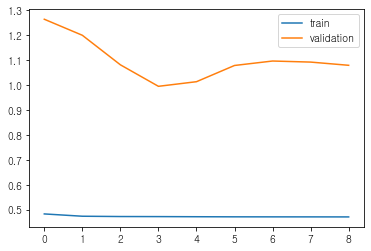

In [27]:
plt.plot(history.history["loss"],label="train")
plt.plot(history.history["val_loss"],label="validation")
plt.legend()
plt.show()

In [28]:
pred_df = pd.DataFrame(pred, columns=['TAG'])

pred_df['TAG'] = pred_df['TAG'].apply(lambda x: 1 if x>=0.5 else 0)

In [29]:
confusion = confusion_matrix(test_label, pred_df)
print(confusion)

[[  2160    780]
 [ 59817 187793]]


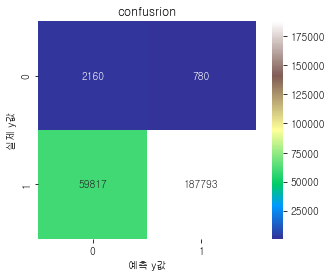

In [30]:
plot = sns.heatmap(confusion ,square=True, annot=True, fmt='d', cmap='terrain')
class_lables=['0','1','2','3']
plt.title("confusrion", size = 12)
plot.set_xlabel('예측 y값')
plot.set_ylabel('실제 y값')
# plt.savefig('80% 사후확률_min_{}_수정.png'.format(j), dpi=300, transparent=True, bbox_inches="tight")
plt.show()

In [31]:
p = precision_score(test_label, pred_df)
print('precision : %0.5f' %p)
r = recall_score(test_label, pred_df)
print('recall : %0.5f' %r)
f1 = f1_score(test_label, pred_df)
print('f1-score : %0.5f' %f1)
acc = accuracy_score(test_label, pred_df)
print('accuracy : %0.5f' %acc)

precision : 0.99586
recall : 0.75842
f1-score : 0.86107
accuracy : 0.75814


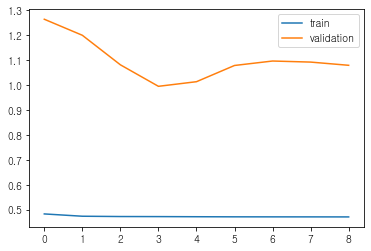

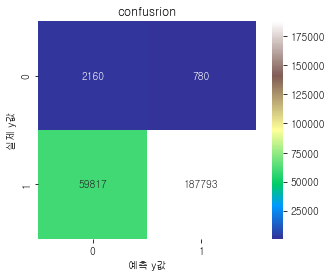

In [33]:
plt.plot(history.history["loss"],label="train")
plt.plot(history.history["val_loss"],label="validation")
plt.legend()
plt.show()

plot = sns.heatmap(confusion ,square=True, annot=True, fmt='d', cmap='terrain')
class_lables=['0','1','2','3']
plt.title("confusrion", size = 12)
plot.set_xlabel('예측 y값')
plot.set_ylabel('실제 y값')
# plt.savefig('80% 사후확률_min_{}_수정.png'.format(j), dpi=300, transparent=True, bbox_inches="tight")
plt.show()